In [70]:
from sklearn.model_selection import train_test_split
import pandas as pd

df_final=pd.read_csv('..\\Assests\\data\\final_insurance_data.csv')
# Split features and target
X = df_final.drop(columns=["claim_status"])
y = df_final["claim_status"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [71]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
import pickle
# Save scaler locally
scaler_path = "..\\Assests\\model\\standard_scaler.pkl"
with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)

In [25]:
import mlflow
import os
import mlflow.sklearn
scaler_path = "..\\Assests\\model\\standard_scaler.pkl"

mlflow.set_experiment('insure_claim_Scaler_log')

with mlflow.start_run(run_name='scaler_log_run'):
    mlflow.log_artifact(scaler_path,artifact_path='Scaler')
    mlflow.log_param('Scaler','Standard Scaler')
    mlflow.log_metric('Train Shape', X_train.shape[0])
    
print(f"Scaler saved as: {os.path.abspath(scaler_path)}")

Scaler saved as: c:\Users\ssutk2\OneDrive - Cardiff University\Documents\ClaimInsure\Assests\model\standard_scaler.pkl


In [29]:
from sklearn.linear_model import LogisticRegression
baselineModel=LogisticRegression(
    penalty='l2',
    C=1.0,
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

In [33]:
from sklearn.metrics import roc_auc_score, f1_score, classification_report
with mlflow.start_run(run_name='LogisticRegressionBaseline'):
    baselineModel.fit(X_train_scaled,y_train)
    yPred=baselineModel.predict(X_test_scaled)
    y_proba=baselineModel.predict_proba(X_test_scaled)[:,1]
    
    auc_roc=roc_auc_score(y_test,y_proba)
    f1= f1_score(y_test,yPred)

    mlflow.log_metric('auc',auc_roc)
    mlflow.log_metric('f1',f1)

    mlflow.log_param("penalty", "l2")
    mlflow.log_param("C", 1.0)
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("max_iter", 1000)

    mlflow.sklearn.log_model(baselineModel, 'logistic regression')
    
    print("✔️ Model logged to MLflow")
    print("AUC Score:", auc_roc)
    print("F1 Score :", f1)

2025/06/15 09:55:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/15 09:55:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔️ Model logged to MLflow
AUC Score: 0.592352970199329
F1 Score : 0.1440084092501752


In [35]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score
import mlflow
import mlflow.sklearn

# Define model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # balance positive class
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Start MLflow run
with mlflow.start_run(run_name="xgboost_baseline"):
    xgb_model.fit(X_train_scaled, y_train)
    y_pred = xgb_model.predict(X_test_scaled)
    y_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    # Log model and metrics
    mlflow.sklearn.log_model(xgb_model, "xgboost_model")
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("F1", f1)

    print("✔️ XGBoost model logged to MLflow")
    print(f"AUC Score: {auc:.4f}")
    print(f"F1 Score : {f1:.4f}")


C:\Users\ssutk2\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [09:57:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025/06/15 09:57:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/15 09:57:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔️ XGBoost model logged to MLflow
AUC Score: 0.5667
F1 Score : 0.1371


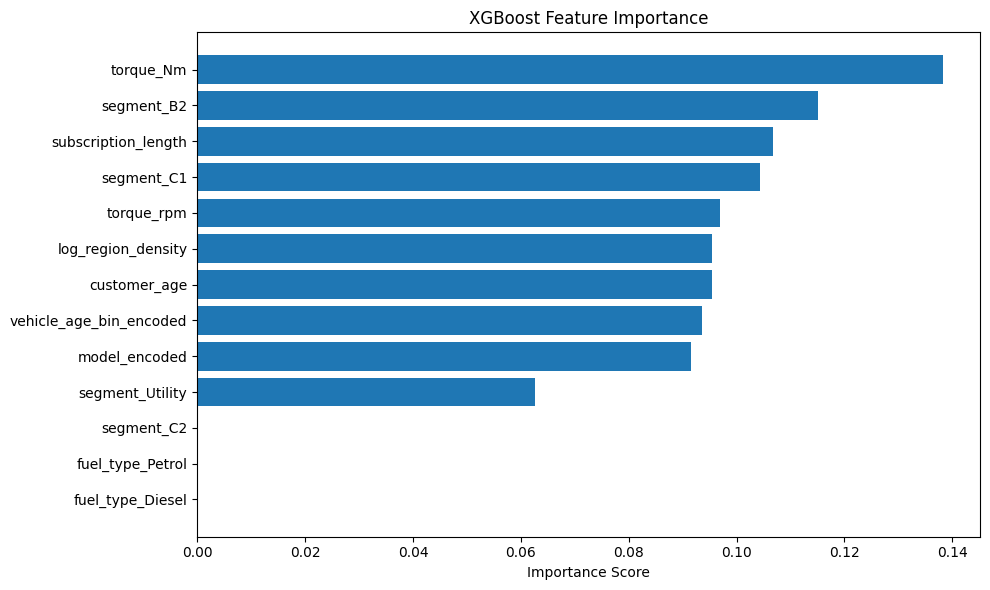

In [38]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
feature_importance = xgb_model.feature_importances_
features = X.columns
sorted_idx = feature_importance.argsort()

plt.barh(features[sorted_idx], feature_importance[sorted_idx])
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [39]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import mlflow
import mlflow.sklearn
from sklearn.metrics import roc_auc_score, f1_score, make_scorer

# Define parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3]
}

# Initialize base model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Define scoring
scorer = make_scorer(f1_score)

# Set up random search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    scoring=scorer,
    cv=3,
    verbose=1,
    n_iter=30,
    random_state=42,
    n_jobs=-1
)

# MLflow logging
with mlflow.start_run(run_name="xgboost_randomsearch"):
    random_search.fit(X_train_scaled, y_train)
    
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("F1", f1)

    mlflow.log_params(random_search.best_params_)
    mlflow.sklearn.log_model(best_model, "xgboost_tuned_model")

    print("✔️ Tuned XGBoost model logged to MLflow")
    print(f"Best Params: {random_search.best_params_}")
    print(f"AUC Score  : {auc:.4f}")
    print(f"F1 Score   : {f1:.4f}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\ssutk2\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:05:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025/06/15 10:05:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/15 10:05:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔️ Tuned XGBoost model logged to MLflow
Best Params: {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}
AUC Score  : 0.6128
F1 Score   : 0.1510


In [44]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, make_scorer
import mlflow
import mlflow.sklearn

# Define parameter grid for CatBoost
param_grid = {
    'iterations': [300, 500, 700],
    'depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'random_strength': [1, 5, 10]
}

# Create base model
cat_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    auto_class_weights='Balanced',
    verbose=0,
    random_seed=42
)

# Define F1 scorer for optimization
scorer = make_scorer(f1_score)

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_grid,
    scoring=scorer,
    n_iter=30,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Start MLflow run
with mlflow.start_run(run_name="catboost_randomsearch"):
    random_search.fit(X_train_scaled, y_train)

    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    # Log to MLflow
    mlflow.log_params(random_search.best_params_)
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("F1", f1)
    mlflow.sklearn.log_model(best_model, "catboost_tuned_model")

    print("✔️ Tuned CatBoost model logged to MLflow")
    print(f"Best Params: {random_search.best_params_}")
    print(f"AUC Score  : {auc:.4f}")
    print(f"F1 Score   : {f1:.4f}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits


2025/06/15 10:21:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/15 10:21:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔️ Tuned CatBoost model logged to MLflow
Best Params: {'subsample': 1.0, 'random_strength': 10, 'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 3}
AUC Score  : 0.6047
F1 Score   : 0.1479


 1. Check for signal in data

Ask: Is there enough predictive power in the features?
Actions:

    Plot feature importances from all your tree models (you’ve done it for XGBoost).

    Use SHAP values (especially for CatBoost or XGBoost) to see if:

        any features consistently drive prediction,

        or if features contribute very little (which means limited signal).

C:\Users\ssutk2\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


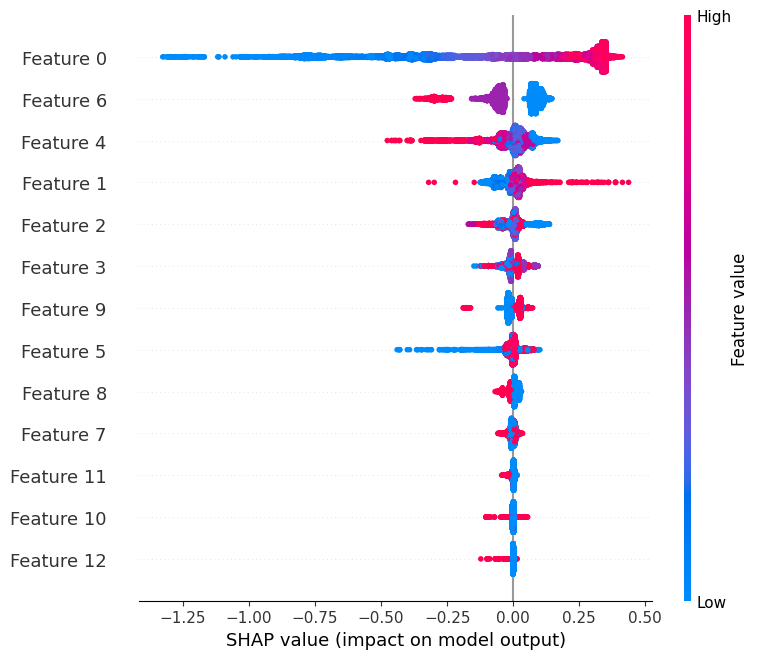

In [45]:
import shap
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled)

📊 2. Check if data is learnable at all

Ask: Is even a high-capacity model able to learn something useful?
Actions:

    Overfit a simple tree (max_depth=10, no regularization) or a CatBoost model with many iterations on a small subset of data (e.g., 2000 samples).

        If it can’t even overfit, that’s a red flag—data has poor separability.



In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Subset small portion of training data
X_small = X_train_scaled[:2000]
y_small = y_train[:2000]

# Train an unconstrained tree
dt = DecisionTreeClassifier(max_depth=20, min_samples_split=2)
dt.fit(X_small, y_small)

# Evaluate on same data (intentionally overfitting)
y_pred = dt.predict(X_small)
print(classification_report(y_small, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1873
           1       1.00      0.98      0.99       127

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000



In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, make_scorer
import mlflow
import mlflow.sklearn

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Create base model
rf_model = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Define F1 scorer
scorer = make_scorer(f1_score)

# Setup randomized search
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    scoring=scorer,
    n_iter=30,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# MLflow logging
with mlflow.start_run(run_name="random_forest_randomsearch"):
    random_search.fit(X_train_scaled, y_train)

    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    # Log to MLflow
    mlflow.log_params(random_search.best_params_)
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("F1", f1)
    mlflow.sklearn.log_model(best_model, "random_forest_tuned_model")

    print("✔️ Tuned Random Forest model logged to MLflow")
    print(f"Best Params: {random_search.best_params_}")
    print(f"AUC Score  : {auc:.4f}")
    print(f"F1 Score   : {f1:.4f}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits


2025/06/15 10:38:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/15 10:39:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔️ Tuned Random Forest model logged to MLflow
Best Params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5, 'bootstrap': True}
AUC Score  : 0.6056
F1 Score   : 0.1517


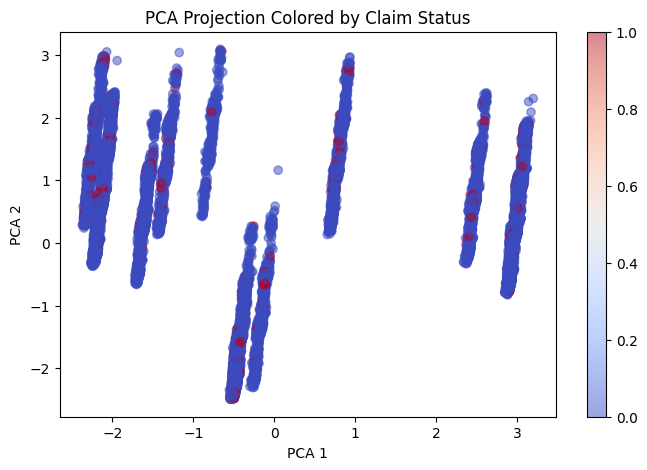

In [48]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='coolwarm', alpha=0.5)
plt.title("PCA Projection Colored by Claim Status")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar()
plt.show()


In [50]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, f1_score
import xgboost as xgb
import mlflow
import mlflow.sklearn

# Apply SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Re-initialize XGBoost (no need for scale_pos_weight when using SMOTE)
final_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    colsample_bytree=1.0,
    gamma=0,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=1,
    n_estimators=500,
    subsample=0.6
)

# Train and log with MLflow
with mlflow.start_run(run_name="xgboost_final_model_smote"):
    final_xgb.fit(X_train_balanced, y_train_balanced)

    y_pred = final_xgb.predict(X_test_scaled)
    y_proba = final_xgb.predict_proba(X_test_scaled)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("F1", f1)
    mlflow.sklearn.log_model(final_xgb, "final_xgboost_model_smote")

    print("✔️ Final XGBoost + SMOTE model trained & logged")
    print(f"AUC Score  : {auc:.4f}")
    print(f"F1 Score   : {f1:.4f}")


C:\Users\ssutk2\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:48:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025/06/15 10:48:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/15 10:48:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔️ Final XGBoost + SMOTE model trained & logged
AUC Score  : 0.5905
F1 Score   : 0.1354


❌ SMOTE introduces synthetic noise	Your dataset already has low signal, and adding "fake" minority examples blurs boundaries more.
⚠️ Minority class is not well-clustered	Your PCA earlier showed claims (class 1) are scattered → SMOTE can't interpolate meaningfully.
🧪 You already had scale_pos_weight	It was handling imbalance quite effectively without data distortion.
⛔ Test set is real, not synthetic	So model trained on SMOTE data may overfit to artificial patterns not seen in test set.

In [81]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score
import mlflow
import mlflow.sklearn

# Final model with best hyperparameters
final_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    colsample_bytree=1.0,
    gamma=0,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=1,
    n_estimators=500,
    subsample=0.6
)

# Train
final_xgb.fit(X_train_scaled, y_train)

# Predict
y_pred = final_xgb.predict(X_test_scaled)
y_proba = final_xgb.predict_proba(X_test_scaled)[:, 1]

# Evaluate
auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

print(f"AUC Score : {auc:.4f}")
print(f"F1 Score  : {f1:.4f}")


C:\Users\ssutk2\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:38:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC Score : 0.6128
F1 Score  : 0.1510


In [79]:
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from sklearn.metrics import roc_auc_score, f1_score
import mlflow

# Define model (no 'early_stopping_rounds' here)
lgb_model = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    class_weight='balanced',
    learning_rate=0.05,
    n_estimators=1000,
    max_depth=5,
    random_state=42
)

mlflow.set_experiment("insure_claim_lightgbm")

with mlflow.start_run(run_name="lightgbm_baseline"):
    lgb_model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_test_scaled, y_test)],
        eval_metric='auc',
        callbacks=[early_stopping(stopping_rounds=50)]
    )

    y_proba = lgb_model.predict_proba(X_test_scaled)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    mlflow.log_params(lgb_model.get_params())
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("F1", f1)
    mlflow.sklearn.log_model(lgb_model, "lightgbm_model")

    print("✔️ LightGBM model trained & logged")
    print(f"AUC Score : {auc:.4f}")
    print(f"F1 Score  : {f1:.4f}")


[LightGBM] [Info] Number of positive: 2801, number of negative: 40531
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 43332, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

C:\Users\ssutk2\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/06/15 11:36:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/15 11:36:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔️ LightGBM model trained & logged
AUC Score : 0.6090
F1 Score  : 0.1484


In [84]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
import mlflow
import mlflow.sklearn

# Define base models with provided hyperparameters
# Define individual models
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=500,
    subsample=0.6,
    gamma=0
)

cat_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    auto_class_weights='Balanced',
    learning_rate=0.05,
    depth=3,
    iterations=300,
    l2_leaf_reg=3,
    subsample=1.0,
    random_strength=10,
    verbose=0,
    random_seed=42
)

lgb_model = LGBMClassifier(
    is_unbalance=True,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=300,
    min_child_samples=20,
    subsample=0.8,
    random_state=42
)

# Create ensemble with soft voting
ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('cat', cat_model),
        ('lgb', lgb_model)
    ],
    voting='soft',
    n_jobs=-1
)

# MLflow tracking
mlflow.set_experiment("insurance_claim_ensemble")

with mlflow.start_run(run_name="xgb_cat_lgb_ensemble"):
    ensemble.fit(X_train_scaled, y_train)
    
    y_proba = ensemble.predict_proba(X_test_scaled)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("F1", f1)
    mlflow.sklearn.log_model(ensemble, "xgb_cat_lgb_model")

    print("✔️ Ensemble model trained & logged")
    print(f"AUC Score : {auc:.4f}")
    print(f"F1 Score  : {f1:.4f}")

2025/06/15 11:43:25 INFO mlflow.tracking.fluent: Experiment with name 'insurance_claim_ensemble' does not exist. Creating a new experiment.
C:\Users\ssutk2\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/06/15 11:43:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/15 11:43:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔️ Ensemble model trained & logged
AUC Score : 0.6062
F1 Score  : 0.1487
